Importing Stuff

In [14]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.datasets import Flowers102
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

Function for displaying images

In [3]:
def show_image_grid(images, num_img = 5, size = (1, 28, 28)):
    img_unflat = images.detach().cpu().reshape(-1, *size)
    img_grid = make_grid(img_unflat[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

Generator Block and Generator Class

In [4]:
def gen_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim = 10, img_dim = 784, hidden_dim = 128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            gen_block(z_dim, hidden_dim),
            gen_block(hidden_dim, hidden_dim * 2),
            gen_block(hidden_dim * 2, hidden_dim * 4),
            gen_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, img_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

Discrimator Block and Class

In [6]:
def disc_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope = 0.2, inplace=True)
    )

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_dim  = 784, hidden_dim = 128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            disc_block(img_dim, hidden_dim * 4),
            disc_block(hidden_dim * 4, hidden_dim * 2),
            disc_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, img):
        return self.disc(img)

Noise Generator

In [8]:
def get_noise(n_samples, z_dim, device = 'cpu'):
    noise = torch.randn(n_samples, z_dim, device=device)
    return noise

Hyper Parameters for Training

In [9]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_steps = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
dataloader = DataLoader(FashionMNIST('./data', download=False, transform=ToTensor()), batch_size=batch_size, shuffle=True)

Initializing Generator Discriminator with Optimizers

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Gettings Losses

In [11]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim, device)
    fake_img = gen(noise)
    disc_pred = disc(fake_img)
    gen_loss = criterion(disc_pred, torch.ones_like(disc_pred))
    return gen_loss

In [12]:
def get_disc_loss(gen, disc, criterion, num_images, z_dim, real, device):

    noise = get_noise(num_images, z_dim, device)
    fake_img = gen(noise)
    disc_fake_pred = disc(fake_img.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

    disc_real_pred = disc(real.detach())
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

Putting Everything Together

  6%|▌         | 28/469 [00:00<00:13, 33.14it/s]

Step 500: Generator loss: 1.0454940425157557, discriminator loss: 0.5229840873479843


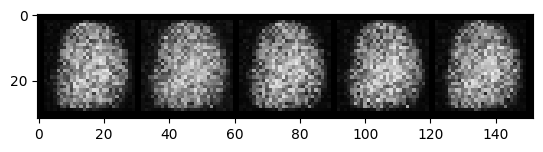

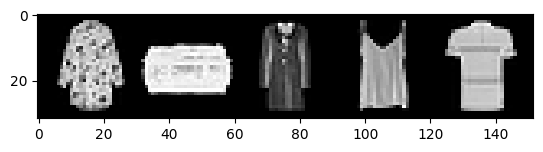

 13%|█▎        | 60/469 [00:01<00:12, 33.54it/s]

Step 1000: Generator loss: 1.305056875467302, discriminator loss: 0.37481962823867815


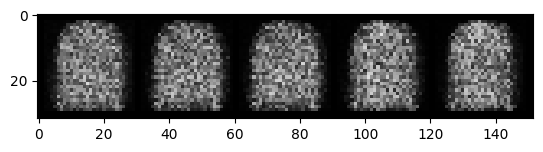

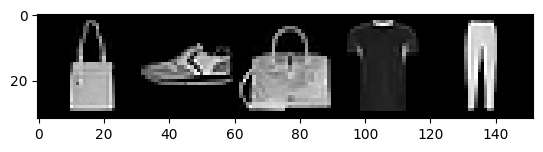

 19%|█▉        | 91/469 [00:02<00:11, 32.37it/s]

Step 1500: Generator loss: 1.1704551644325267, discriminator loss: 0.4291673843860623


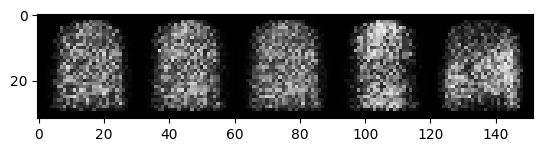

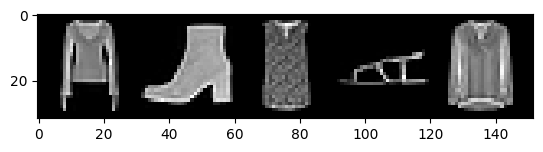

 26%|██▋       | 124/469 [00:03<00:10, 32.45it/s]

Step 2000: Generator loss: 1.19268151473999, discriminator loss: 0.4062495069503785


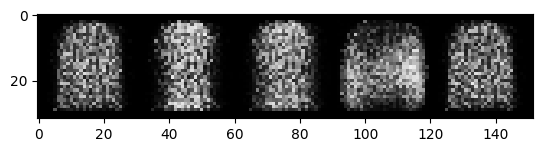

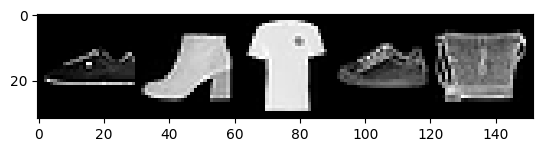

 33%|███▎      | 153/469 [00:05<00:11, 26.65it/s]

Step 2500: Generator loss: 1.28536488032341, discriminator loss: 0.40108155137300516


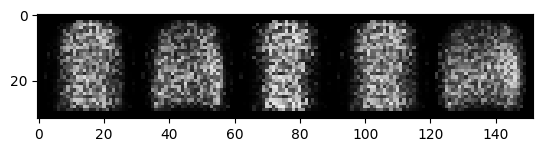

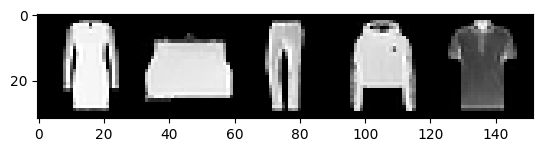

 40%|███▉      | 186/469 [00:07<00:10, 26.19it/s]

Step 3000: Generator loss: 1.350226827621461, discriminator loss: 0.3964680916666984


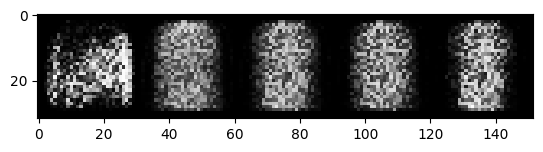

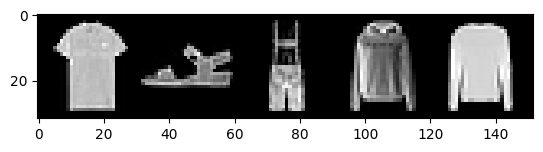

 46%|████▌     | 216/469 [00:06<00:07, 32.81it/s]

Step 3500: Generator loss: 1.4859272522926343, discriminator loss: 0.35974110728502257


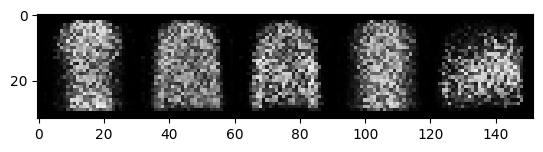

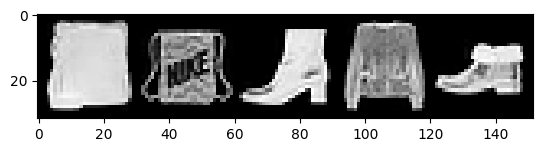

 53%|█████▎    | 248/469 [00:07<00:06, 33.06it/s]

Step 4000: Generator loss: 1.604013060331344, discriminator loss: 0.3274760104417804


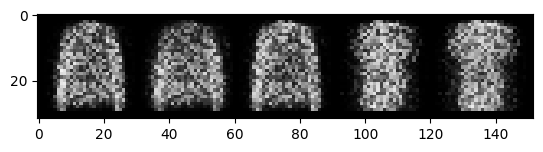

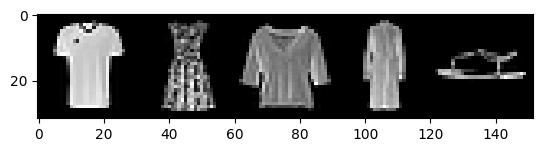

 59%|█████▉    | 276/469 [00:08<00:05, 32.76it/s]

Step 4500: Generator loss: 1.6550006232261643, discriminator loss: 0.339064397931099


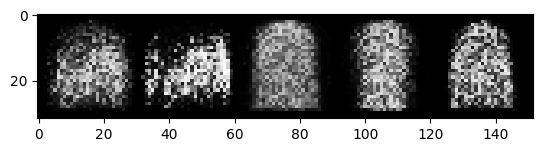

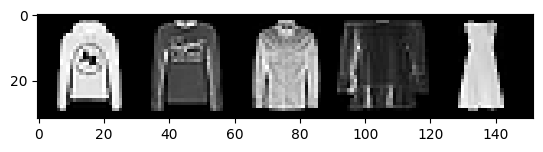

 30%|███       | 143/469 [00:05<00:12, 25.87it/s]


KeyboardInterrupt: 

In [16]:
mean_generator_loss = 0
mean_discriminator_loss = 0
cur_step = 0

for epoch in range(n_epochs):
    
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        #For Discriminator
        disc_opt.zero_grad()

        disc_loss = get_disc_loss(gen, disc, criterion, cur_batch_size, z_dim, real, device)

        disc_loss.backward(retain_graph=True)

        disc_opt.step()

        #For Generator
        gen_opt.zero_grad()

        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)

        gen_loss.backward(retain_graph=True)

        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_steps
        mean_generator_loss += gen_loss.item() / display_steps

        if cur_step % display_steps == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device)
            fake = gen(fake_noise)
            show_image_grid(fake)
            show_image_grid(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

